In [1]:
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import mdof
from mdof.utilities.printing import plot_pred

# Load Files

In [2]:
# Path to the directory where files are saved
DATA_DIR = Path("../../uploads/mini_shake_table/Sienna's Trials")
# Get all the files ending in csv
files = list(DATA_DIR.glob("**/*.csv"))
# Identify the row with the column labels
header_row = 8
# Get the column labels
with open(files[0], "r") as readfile:
    header_keys = readfile.readlines()[header_row-1].split(',')
# Identify the column indices for each acceleration component
x_index = header_keys.index('Acc_X')
y_index = header_keys.index('Acc_Y')
z_index = header_keys.index('Acc_Z')

# Populate a dictionary with the data. Each file is its own item.
data = {}
for file in files:
    filename = f"{file.parent.name} - {file.name.split(':')[0]}"
    data[filename] = np.loadtxt(file,
                                delimiter=",",
                                skiprows=header_row, # Get all the rows after the header
                                usecols=[x_index,y_index,z_index] # Get only the columns with acceleration data
                               )

## Print the filenames used as keys in the `data` dictionary

In [3]:
# We'll use this list of filenames as reference for the options 
# of records used in the system identification code down below.

for filename in data.keys():
    print(filename)

Middle Sensor (85) - Trial A
Middle Sensor (85) - Trial B
Middle Sensor (85) - Trial C
Bottom Sensor (86) - Trial A
Bottom Sensor (86) - Trial B
Bottom Sensor (86) - Trial C
Top Sensor (7B) - Trial A
Top Sensor (7B) - Trial C
Top Sensor (7B) - Trial B


# Plot the records

In [4]:
## TODO: Fill this part in to get the time array!
SAMPLE_RATE = 60 #Hz
# If there are sampling_rate samples taken per second, what is the amount of time between each sample?
# That is, how many seconds per sample?
TIME_STEP = 1/SAMPLE_RATE 
# Create a function that returns a time array that starts at zero,
# has a length of num_points, and has a step of time_step between
# each point.
# note: the syntax for np.linspace is np.linspace(start,stop,length)
def time_array(time_step, num_points):
    return np.linspace(0,time_step*num_points,num_points)

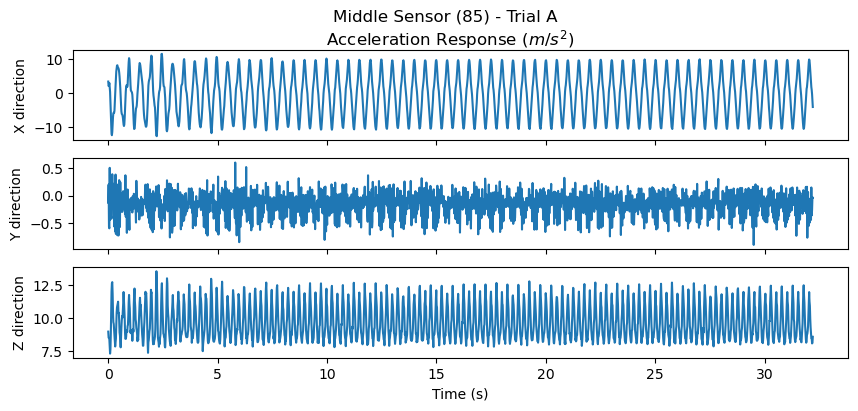

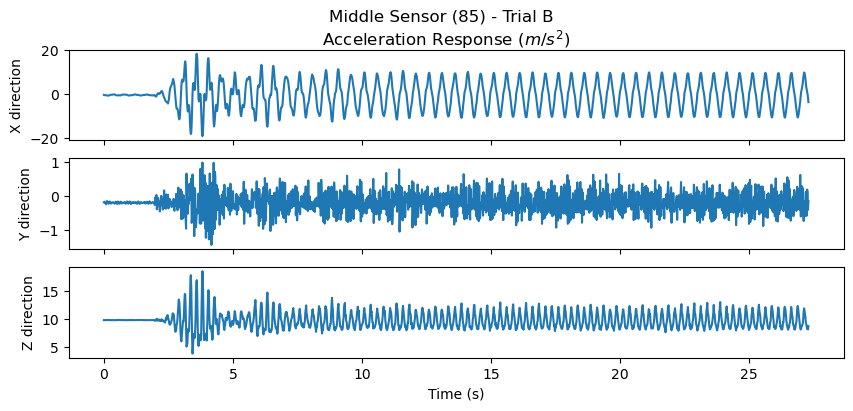

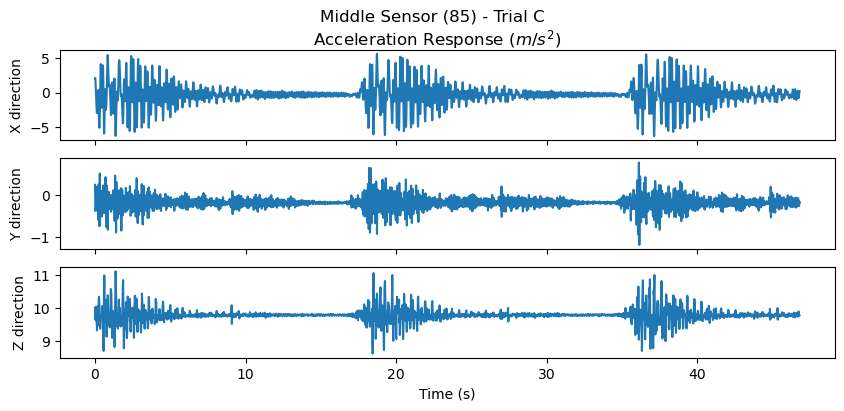

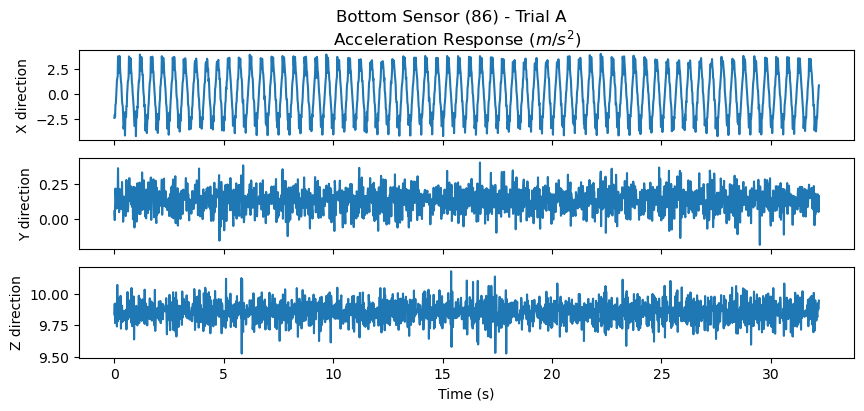

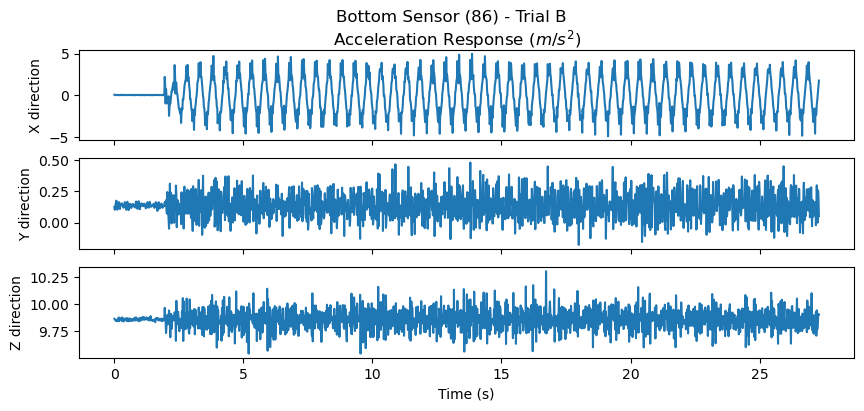

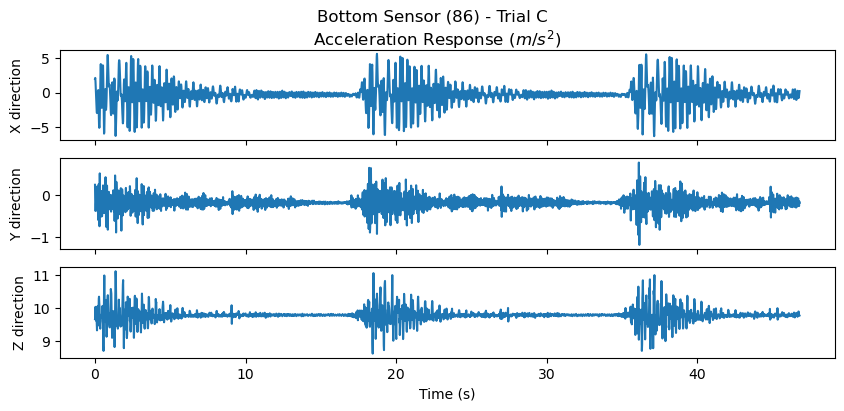

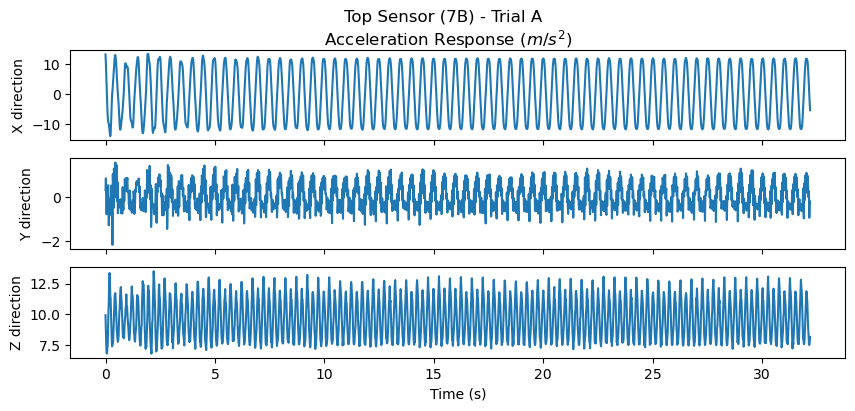

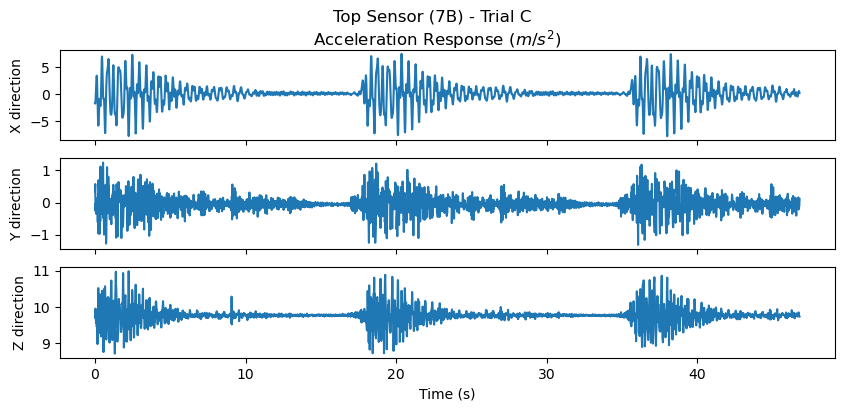

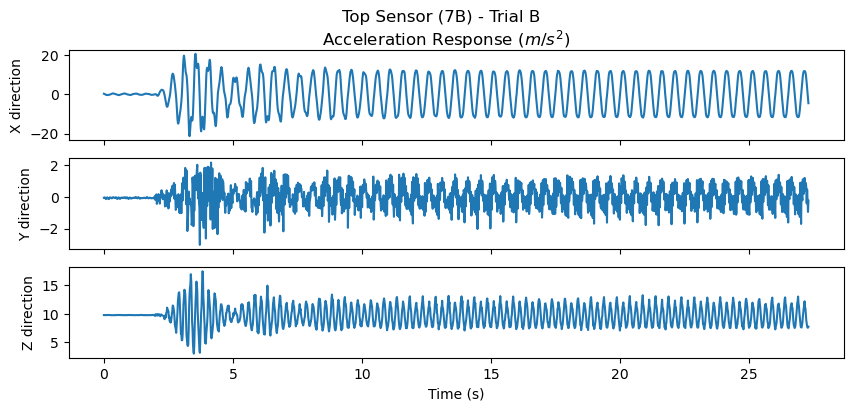

In [5]:
# Path to a directory where we'll save figures
OUT_DIR = Path("out/")
if not OUT_DIR.exists():
    OUT_DIR.mkdir()
# TODO: Fill in this part to plot the records!
for filename,record in data.items():
    # Truncate the record to a shorter portion
    num_points = int(record.shape[0]/3)
    record = record[num_points:2*num_points,:]
    # Create the time array
    time = time_array(TIME_STEP,num_points)
    # Create a plot
    fig,ax = plt.subplots(3,1, figsize=(10,4), sharex=True)
    # Plot the X direction, which is the first column of record
    ax[0].plot(time, record[:,0])
    ax[0].set_ylabel('X direction')
    # Plot the Y direction, which is the second column of record
    ax[1].plot(time, record[:,1])
    ax[1].set_ylabel('Y direction')
    # Plot the Z direction, which is the third column of record
    ax[2].plot(time, record[:,2])
    ax[2].set_ylabel('Z direction')
    # Labels, limits and title
    ax[2].set_xlabel('Time (s)')
    fig.suptitle(f"{filename} \n Acceleration Response ($m/s^2$)")
    # Save the figure
    fig.savefig(OUT_DIR/f"{filename}.png")

# Perform System Identification.

Given a model trained on the Northridge earthquake record, can we predict the response to the sine wave?

Spectral quantities:
       T(s)        ζ        EMACO      MPC       EMACO*MPC
      0.2932     -0.01482   1.0        1.0        1.0      
      0.2738     0.008895   1.0        1.0        1.0      
      0.2671     0.0183     1.0        1.0        1.0      
      0.2447     0.02769    1.0        1.0        1.0      
      0.242      -0.0122    1.0        1.0        1.0      
      0.2351     0.005044   1.0        1.0        1.0      
      0.2224     0.01182    1.0        1.0        1.0      
      0.1969     0.007949   1.0        1.0        1.0      
      0.1642     0.001736   1.0        1.0        1.0      
      0.1496     -0.003294  1.0        1.0        1.0      
Mean Period(s): 0.22888876435374125
Standard Dev(s): 0.04427516385786257


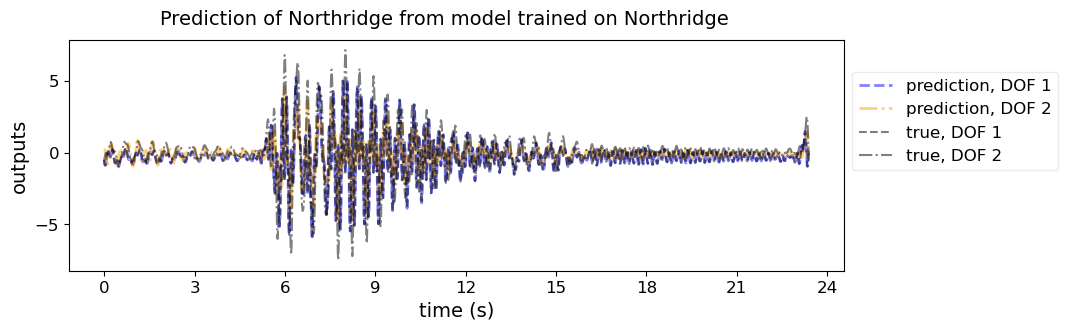

In [6]:
# Train a model based on the Northridge earthquake record.

# Load the X component of the bottom sensor from Northridge as input
inputs = data['Bottom Sensor (86) - Trial C'][:,0]
num_points = int(inputs.shape[0]/6)
inputs = inputs[num_points:2*num_points]
# Load the middle and top sensors from Northridge as outputs
outputs = np.array([data['Middle Sensor (85) - Trial C'],
                    data['Top Sensor (7B) - Trial C']])[:,num_points:2*num_points,0]
# Construct the time array
time = time_array(TIME_STEP, len(inputs))
# Use the mdof package to perform system identification and construct a model
realization = mdof.sysid(inputs,outputs)
# Find the natural modes of vibration of this model
modes = mdof.modal.system_modes(realization,TIME_STEP)
mdof.utilities.print_modes(modes)
# Stabilize the model in case it isn't already stable
from mdof.validation import stabilize_discrete
A_stable = stabilize_discrete(A=realization[0])
realization = (A_stable,*realization[1:])
# Plot the accuracy of the prediction from this model
fig,ax = plt.subplots(figsize=(10,3))
prediction = mdof.simulate.simulate(realization,inputs)
pred_fig = plot_pred(ytrue=outputs,
                     models=prediction,
                     t=time,
                     figax=(fig,ax),
                     title="Prediction of Northridge from model trained on Northridge")

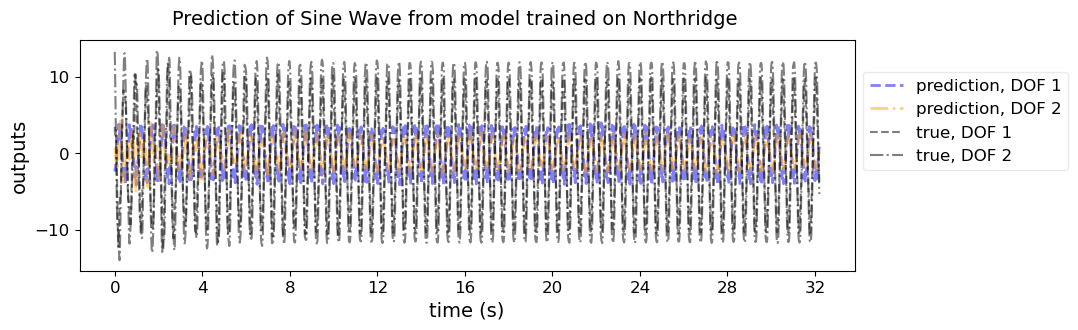

In [7]:
# Test the model on the sine wave record.

# Load the X component of the bottom sensor from SINE WAVE as input
inputs = data['Bottom Sensor (86) - Trial A'][:,0]
num_points = int(inputs.shape[0]/3)
inputs = inputs[num_points:2*num_points]
# Construct the time array
time = time_array(TIME_STEP, len(inputs))
# Plot the accuracy of the prediction from this model
fig,ax = plt.subplots(figsize=(10,3))
prediction = mdof.simulate.simulate(realization,inputs)
# Note that the prediction is made using the inputs and the model trained on Northridge.
# The outputs were not known at the time of prediction.
# Load the middle and top sensors from SINE WAVE as outputs
outputs = np.array([data['Middle Sensor (85) - Trial A'],
                    data['Top Sensor (7B) - Trial A']])[:,num_points:2*num_points,0]
pred_fig = plot_pred(ytrue=outputs,
                     models=prediction,
                     t=time,
                     figax=(fig,ax),
                     title="Prediction of Sine Wave from model trained on Northridge")